In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import HTMLWriter
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import convolve
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import pickle
import stimgenerate as sg
import matplotlib.patches as mpatches
import pandas as pd
import scipy.stats as stats
import matplotlib.patches as patches
from neo.core import SpikeTrain
from quantities import ms
import quantities as pq
from elephant.spike_train_dissimilarity import victor_purpura_distance
from scipy.optimize import differential_evolution
from scipy.special import expit
from scipy.stats import wasserstein_distance
from scipy.integrate import simpson
import random
from scipy.stats import pearsonr

# Load data

In [7]:
res_file = r"results/091825B_results.mat"
f = h5py.File(res_file)
for cell in f['results']['NaturalMovingObjectAndFlash'][1:]:
    if len(f[cell[0]]) < 20:
        continue

    trajx_n = []    
    trajy_n = []    
    trajx_c = []    
    trajy_c = []
    motion_seed_n = []
    motion_seed_c = []    
    spike_indices_n = []
    spike_indices_c = []
    epoch_id_n = []
    epoch_id_c = []
    trans_x_n = []
    trans_y_n = []
    trans_x_c = []
    trans_y_c = []
    trajx_f = []
    trajy_f = []
    motion_seed_f = []
    spike_indices_f = []
    epoch_id_f = []
    trans_x_f = []
    trans_y_f = []

    for cx,cy,si,t,s,en,tx,ty in zip(f[cell[0]]['cx'][0][:], f[cell[0]]['cy'][0][:],f[cell[0]]['spike_indices'][0][:], f[cell[0]]['cur_motion_type'][0][:], f[cell[0]]['motion_seed'][0][:], f[cell[0]]['epoch_id'][0][:],f[cell[0]]['trans_x'][0][:],f[cell[0]]['trans_y'][0][:]):
        # if f[s][:][0] <201 or f[s][:][0] > 300:
        #     continue

        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'natural':
            trajx_n.extend(f[cx][:])
            trajy_n.extend(f[cy][:])
            motion_seed_n.extend(f[s][:])
            spike_indices_n.append(f[si][:])
            epoch_id_n.append(f[en][:])
            trans_y_n.extend(f[ty][:])
            trans_x_n.extend(f[tx][:])

        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'control':
            trajx_c.extend(f[cx][:])
            trajy_c.extend(f[cy][:])
            motion_seed_c.extend(f[s][:])
            spike_indices_c.append(f[si][:])
            epoch_id_c.append(f[en][:])
            trans_x_c.extend(f[tx][:])
            trans_y_c.extend(f[ty][:])

        if "".join(np.vectorize(chr)(f[t][:]).flatten()) == 'flash':
            trajx_f.extend(f[cx][:])
            trajy_f.extend(f[cy][:])
            motion_seed_f.extend(f[s][:])
            spike_indices_f.append(f[si][:])
            epoch_id_f.append(f[en][:])
            trans_x_f.extend(f[tx][:])
            trans_y_f.extend(f[ty][:])
    break # only use the first cell, for this example



trajx_n = np.asarray(trajx_n)
trajy_n = np.asarray(trajy_n)
trajx_c = np.asarray(trajx_c)
trajy_c = np.asarray(trajy_c)
trajx_f = np.asarray(trajx_f)
trajy_f = np.asarray(trajy_f)
motion_seed_n = np.asarray(motion_seed_n)
motion_seed_c = np.asarray(motion_seed_c)
motion_seed_f = np.asarray(motion_seed_f)
epoch_id_n = np.asarray(epoch_id_n)
epoch_id_c = np.asarray(epoch_id_c)
epoch_id_f = np.asarray(epoch_id_f)
trans_x_n = np.asarray(trans_x_n)
trans_x_c = np.asarray(trans_x_c)
trans_x_f = np.asarray(trans_x_f)
trans_y_n = np.asarray(trans_y_n)
trans_y_c = np.asarray(trans_y_c)
trans_y_f = np.asarray(trans_y_f)
trajx_n = trajx_n + trans_x_n
trajy_n = trajy_n + trans_y_n
trajx_c = trajx_c + trans_x_c
trajy_c = trajy_c + trans_y_c
trajx_f = trajx_f + trans_x_f
trajy_f = trajy_f + trans_y_f

cells_n = []
for i in range(len(trans_x_n)):
    if trans_x_n[i] == 0:
        cells_n.append(1)
    if trans_x_n[i] == 84:
        if trans_y_n[i] > 0:
            cells_n.append(3)
        if trans_y_n[i] < 0:
            cells_n.append(7)
    if trans_x_n[i] == 168:
        cells_n.append(2)
    if trans_x_n[i] == -84:
        if trans_y_n[i] > 0:
            cells_n.append(4)
        if trans_y_n[i] < 0:
            cells_n.append(6)
    if trans_x_n[i] == -168:
        cells_n.append(5)

cells_c = []
for i in range(len(trans_x_c)):
    if trans_x_c[i] == 0:
        cells_c.append(1)
    if trans_x_c[i] == 84:
        if trans_y_c[i] > 0:
            cells_c.append(3)
        if trans_y_c[i] < 0:
            cells_c.append(7)
    if trans_x_c[i] == 168:
        cells_c.append(2)
    if trans_x_c[i] == -84:
        if trans_y_c[i] > 0:
            cells_c.append(4)
        if trans_y_c[i] < 0:
            cells_c.append(6)
    if trans_x_c[i] == -168:
        cells_c.append(5)

cells_f = []
for i in range(len(trans_x_f)):
    if trans_x_f[i] == 0:
        cells_f.append(1)
    if trans_x_f[i] == 84:
        if trans_y_f[i] > 0:
            cells_f.append(3)
        if trans_y_f[i] < 0:
            cells_f.append(7)
    if trans_x_f[i] == 168:
        cells_f.append(2)
    if trans_x_f[i] == -84:
        if trans_y_f[i] > 0:
            cells_f.append(4)
        if trans_y_f[i] < 0:
            cells_f.append(6)
    if trans_x_f[i] == -168:
        cells_f.append(5)






cells_n = np.asarray(cells_n)
cells_c = np.asarray(cells_c)
cells_f = np.asarray(cells_f)

In [8]:
def block_stats_all(matrix, n_real):

    real_real = matrix[0:n_real, 0:n_real]
    real_model = matrix[0:n_real, n_real:]
    model_model = matrix[n_real:, n_real:]
    
    stats = []
    for label, block in zip(["Real–Real", "Real–Model", "Model–Model"],
                              [real_real, real_model, model_model]):
        mean_val = block.mean()
        range_val = block.max() - block.min()
        std_val = block.std()
        cv_val = std_val / mean_val if mean_val != 0 else 0
        stats.append([label, f"{mean_val:.2f}", f"{range_val:.2f}", f"{std_val:.2f}", f"{cv_val:.2f}"])
    return stats


def spatial_filterSF(rf,A=0.2):
    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=0.2, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))


def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=0.4, A_s=0.2):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround

def biphasic_temporal_filter(t, p1, p2, tau1, tau2, n):
    t = np.asarray(-t, dtype=float)
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    return term1 - term2
def biphasic_temporal_filter_norm0(t, p1, p2, tau1, tau2, n):
    # Ensure t as positive duration array
    t = np.asarray(-t, dtype=float)
    # Compute the two cascaded low-pass terms
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    # Combine to biphasic raw filter
    filt = term1 - term2

    area = simpson(filt, t)
    filt -= area / (t[-1] - t[0])
    return filt
def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(sigma_x, sigma_y, A, sigma_c, sigma_s, A_c, A_s , noise_input, temporal_filter, type,rf_estimated):   

    T, Y, X = noise_input.shape 
    x = np.linspace(-(X-1)/2, (X-1)/2, X)
    y = np.linspace(-(Y-1)/2, (Y-1)/2, Y)
    noise_input = noise_input.astype(np.float32)
    
    if type == 'gaussian':
        spatial_rf = gaussian_2d(x, y, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    if type == 'difference_of_gaussians':
        spatial_rf = difference_of_gaussians(x, y, sigma_c, sigma_s, A_c, A_s)  # Shape: (Y,X)
    if type == 'SFfitting':
        spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)

    return filtered_movie

def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate * expit(gain * (linear_output + C))
    elif method == 'sigmoidgc':
        gain = kwargs.get('gain', 0.05)
        max_rate = kwargs.get('max_rate', 1500.0)
        C = kwargs.get('y', -37256.659)
        return max_rate / (0.04 + np.exp(-gain * (linear_output+165)))  + C
    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)
    elif method == 'threshold_lineargc':
        theta = kwargs.get('theta', 0)
        return np.maximum(0, linear_output - theta)
    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")

# Gain control definition
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v

def plot_distance(NCompareEmd, seeds_min, seeds_max,label, title):
    meansemd  = np.nanmean(NCompareEmd, axis=0)[::-1]
    rangesemd = np.nanmax(NCompareEmd, axis=0)[::-1] - np.nanmin(NCompareEmd, axis=0)[::-1]
    stdsemd   = np.nanstd(NCompareEmd, axis=0, ddof=0)[::-1]
    cvemd     = stdsemd / meansemd
    table_data   = np.vstack([meansemd, rangesemd, stdsemd, cvemd]).T   # shape (7,4)
    cell_labels  = [f'Cell {i}' for i in range(1,8)]
    cell_labels = cell_labels[::-1]
    metric_labels = ['Mean', 'Range', 'Std', 'CV']

    fig = plt.figure(figsize=(20, 6))
    gs  = fig.add_gridspec(1, 2, width_ratios=[5, 2], wspace=0.1)

    ax0 = fig.add_subplot(gs[0, 0])
    im  = ax0.imshow(
        NCompareEmd.T,
        cmap='coolwarm',
        aspect='auto',
        origin='lower',
        extent=[seeds_min, seeds_max, 1, 7]
    )
    cbar = fig.colorbar(im, ax=ax0, orientation='vertical', pad=0.02)
    cbar.set_label(label)
    ax0.set_xlabel('Seed')
    ax0.set_ylabel('Cell index')
    ax0.set_title(title)

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.axis('off')
    tbl = ax1.table(
        cellText=np.round(table_data, 2).tolist(),
        rowLabels=cell_labels,
        colLabels=metric_labels,
        cellLoc='center',
        loc='center'
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(0.8, 3.5)  # adjust row height
    plt.show()

def compute_rf_from_cells(cell_subsets, spike_trains_nemd, epochD, delayedframes, board_shape, h5_filename):
    binsSF = np.arange(0, epochD*152, epochD) 
    spikecountsNeval = []
    movies_neval = []

    with h5py.File(h5_filename, 'r') as f:
        movies_n = f['stimuli']
        for i in cell_subsets: 
            countstemNeval, _ = np.histogram(spike_trains_nemd[i], bins=binsSF)
            spikecountsNeval.append(countstemNeval)
            movies_neval.append(movies_n[i])

    sum_responseNeval = np.zeros(board_shape, dtype=float)
    sum_stim_countNeval = np.zeros(board_shape, dtype=float)

    for trial_stim, trial_spike_counts in zip(movies_neval, spikecountsNeval):
        num_flashes = len(trial_spike_counts)
        for flash_idx in range(num_flashes):
            if flash_idx < delayedframes:
                continue
            stim_frame_idx = flash_idx - delayedframes
            if stim_frame_idx >= trial_stim.shape[0]:
                continue
            mask = trial_stim[stim_frame_idx]
            count = trial_spike_counts[flash_idx]
            sum_responseNeval += mask * count
            sum_stim_countNeval += mask

    with np.errstate(divide='ignore', invalid='ignore'):
        rfNeval = np.true_divide(sum_responseNeval, sum_stim_countNeval)
        rfNeval[~np.isfinite(rfNeval)] = 0

    if np.max(rfNeval) > 0:
        rfNeval = rfNeval / np.max(rfNeval)
    return rfNeval

def compute_rf_from_seeds(seed_subset, motion_seed_n, spike_trains_nemd, epochD, delayedframes, board_shape, h5_filename):
    binsSF = np.arange(0, epochD*152, epochD) 
    spikecountsNeval = []
    movies_neval = []
    
    with h5py.File(h5_filename, 'r') as f:
        movies_n = f['stimuli']
        for s in seed_subset:
            for i in np.where(motion_seed_n == s)[0]:
                countstemNeval, _ = np.histogram(spike_trains_nemd[i], bins=binsSF)
                spikecountsNeval.append(countstemNeval)
                movies_neval.append(movies_n[i])

    sum_responseNeval = np.zeros(board_shape, dtype=float)
    sum_stim_countNeval = np.zeros(board_shape, dtype=float)

    for trial_stim, trial_spike_counts in zip(movies_neval, spikecountsNeval):
        num_flashes = len(trial_spike_counts)
        for flash_idx in range(num_flashes):
            if flash_idx < delayedframes:
                continue
            stim_frame_idx = flash_idx - delayedframes
            if stim_frame_idx >= trial_stim.shape[0]:
                continue
            mask = trial_stim[stim_frame_idx]
            count = trial_spike_counts[flash_idx]
            sum_responseNeval += mask * count
            sum_stim_countNeval += mask

    with np.errstate(divide='ignore', invalid='ignore'):
        rfNeval = np.true_divide(sum_responseNeval, sum_stim_countNeval)
        rfNeval[~np.isfinite(rfNeval)] = 0

    if np.max(rfNeval) > 0:
        rfNeval = rfNeval / np.max(rfNeval)
    return rfNeval

def flatten_and_corr(a, b):
    a_flat, b_flat = a.flatten(), b.flatten()
    mask = np.logical_and(~np.isnan(a_flat), ~np.isnan(b_flat))
    return pearsonr(a_flat[mask], b_flat[mask])[0]

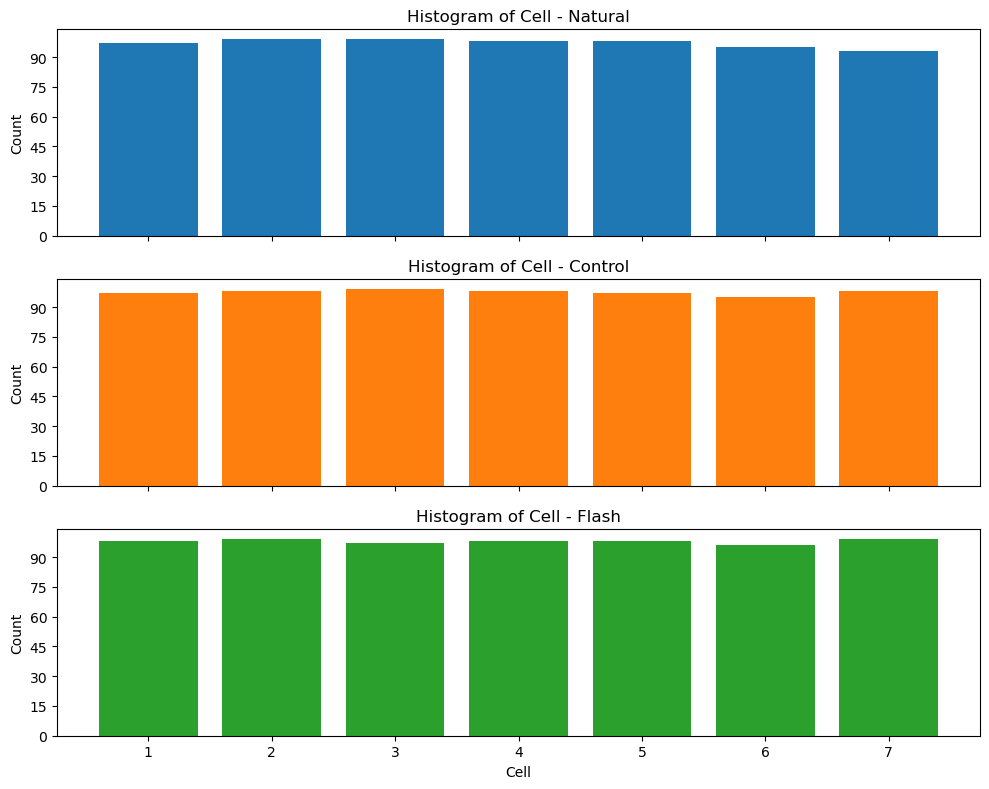

In [9]:
uc_n,cn = np.unique(cells_n,return_counts=True)
uc_c,cc = np.unique(cells_c,return_counts=True)
uc_f,cf = np.unique(cells_f,return_counts=True)

cn = cn.astype(int)
cc = cc.astype(int)
cf = cf.astype(int)



fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].bar(uc_n, cn, color='tab:blue')
axs[0].set_title('Histogram of Cell - Natural')
axs[0].set_ylabel('Count')
axs[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # y axis must be int

axs[1].bar(uc_c, cc, color='tab:orange')
axs[1].set_title('Histogram of Cell - Control')
axs[1].set_ylabel('Count')
axs[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # y axis must be int

axs[2].bar(uc_f, cf, color='tab:green')
axs[2].set_title('Histogram of Cell - Flash')
axs[2].set_xlabel('Cell')
axs[2].set_ylabel('Count')
axs[2].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # y axis must be int

plt.tight_layout()
plt.show()





Natural seeds with count != 7: [ 91.  92.  93.  94.  95.  96.  97.  98.  99. 100.]
Control seeds with count != 7: [ 91.  92.  93.  94.  95.  96.  98.  99. 100.]
Flash seeds with count != 7: [ 91.  92.  94.  96.  97.  98. 100.]


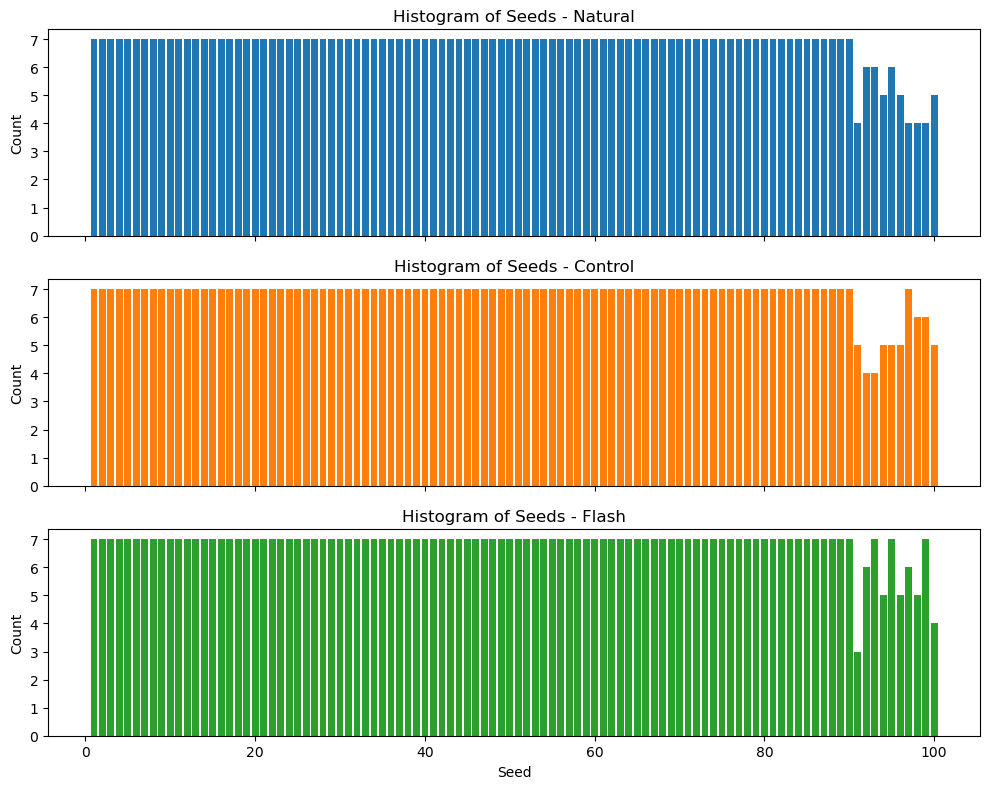

In [10]:

# Count occurrences of each seed for each type, ensuring y (counts) are int
unique_n, counts_n = np.unique(motion_seed_n, return_counts=True)
unique_c, counts_c = np.unique(motion_seed_c, return_counts=True)
unique_f, counts_f = np.unique(motion_seed_f, return_counts=True)

# Ensure counts are integers
counts_n = counts_n.astype(int)
counts_c = counts_c.astype(int)
counts_f = counts_f.astype(int)

# Find seeds where counts are not 7
not7_n = unique_n[counts_n != 7]
not7_c = unique_c[counts_c != 7]
not7_f = unique_f[counts_f != 7]

print("Natural seeds with count != 7:", not7_n)
print("Control seeds with count != 7:", not7_c)
print("Flash seeds with count != 7:", not7_f)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].bar(unique_n, counts_n, color='tab:blue')
axs[0].set_title('Histogram of Seeds - Natural')
axs[0].set_ylabel('Count')
axs[0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # y axis must be int

axs[1].bar(unique_c, counts_c, color='tab:orange')
axs[1].set_title('Histogram of Seeds - Control')
axs[1].set_ylabel('Count')
axs[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # y axis must be int

axs[2].bar(unique_f, counts_f, color='tab:green')
axs[2].set_title('Histogram of Seeds - Flash')
axs[2].set_xlabel('Seed')
axs[2].set_ylabel('Count')
axs[2].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # y axis must be int

plt.tight_layout()
plt.show()

# Comparison B/W Natural and Control

In [12]:
n_seeds  = 100
seeds_min = 1
seeds_max = 100 
q = 1.0 / (100.0 * pq.ms)  
NCompareVp = np.zeros((244, 7))
NCompareEmd = np.zeros((244, 7))
Normalizedrateidx = np.zeros((244, 7))
delay = 3/60 # s

In [13]:
len(spike_indices_n),len(spike_indices_c),len(spike_indices_f)

(679, 682, 685)

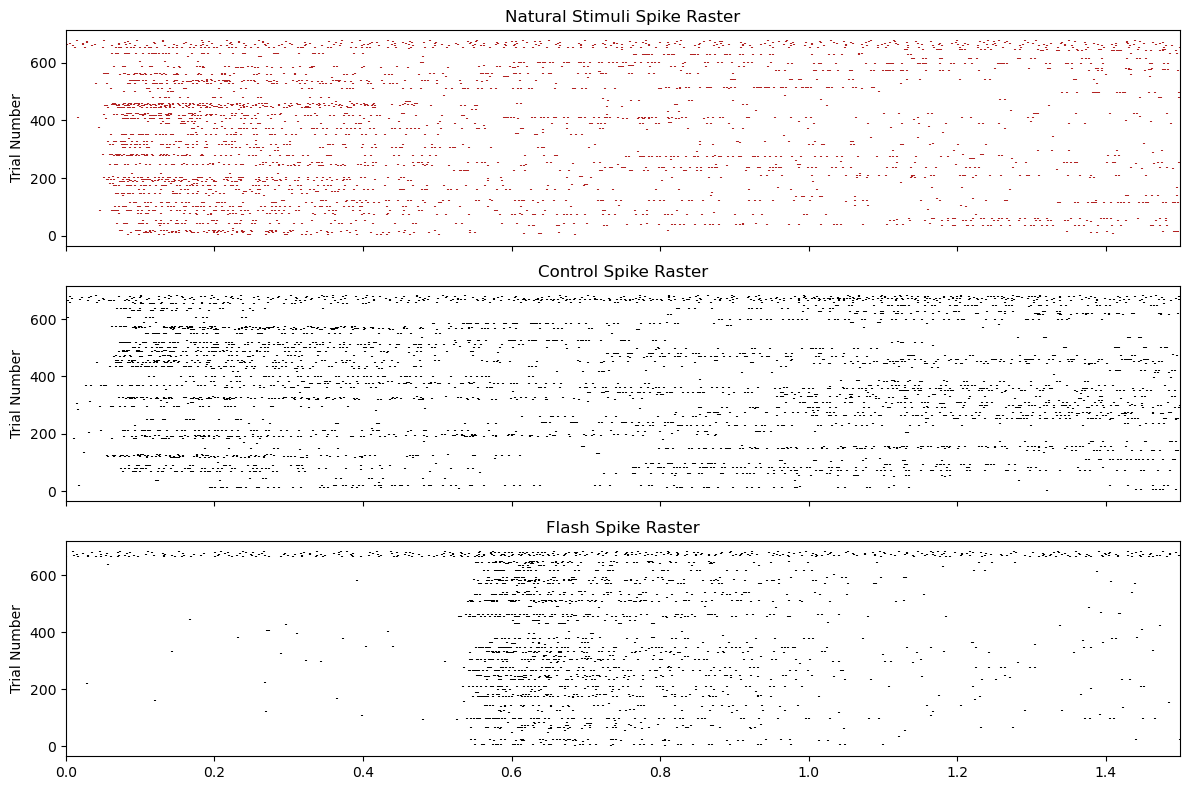

In [14]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

num_trials_n = len(spike_indices_n)
spikes_n = []
for spike_idx_n in range(num_trials_n):
    spikes_in_trial = spike_indices_n[spike_idx_n] / 10000 - delay
    spikes_n.extend(spikes_in_trial)
    ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'firebrick', linewidth=1.5)


spikes_c = []
num_trials_c = len(spike_indices_c)
for spike_idx_c in range(num_trials_c):
    spikes_in_trial = spike_indices_c[spike_idx_c] / 10000 - delay
    spikes_c.extend(spikes_in_trial)
    ax2.vlines(spikes_in_trial, spike_idx_c, spike_idx_c + 1, 'k', linewidth=1.5)

spikes_f = []
num_trials_f = len(spike_indices_f)
for spike_idx_f in range(num_trials_f):
    spikes_in_trial = spike_indices_f[spike_idx_f] / 10000 - delay
    spikes_f.extend(spikes_in_trial)
    ax3.vlines(spikes_in_trial, spike_idx_f, spike_idx_f + 1, 'k', linewidth=1.5)

ax1.set_ylabel('Trial Number')
ax1.set_title('Natural Stimuli Spike Raster')
ax1.set_xlim(0, 1.5)  


ax2.set_ylabel('Trial Number')
ax2.set_title('Control Spike Raster')
ax2.set_xlim(0, 1.5)  

ax3.set_ylabel('Trial Number')
ax3.set_title('Flash Spike Raster')
ax3.set_xlim(0, 1.5)  

plt.tight_layout()
plt.show()

In [15]:
for i in range(len(spike_indices_c)):
    if np.array_equal(spike_indices_c[i], np.array([0, 0])):
        spike_indices_c[i] = np.array([])

for i in range(len(spike_indices_n)):
    if np.array_equal(spike_indices_n[i], np.array([0, 0])):
        spike_indices_n[i] = np.array([])

for i in range(len(spike_indices_f)):
    if np.array_equal(spike_indices_f[i], np.array([0, 0])):
        spike_indices_f[i] = np.array([])







In [93]:
# for seeds in range(1,245):
#     if seeds in not7_n:
#         continue

#     group_n = np.where(motion_seed_n == seeds)[0]
#     group_c = np.where(motion_seed_c == seeds)[0]
#     cell_pos_n = cells_n[group_n]
#     cell_pos_c = cells_c[group_c]
#     print(seeds)

#     print(group_n)
#     print(group_c)
#     print(cell_pos_n)
#     print(cell_pos_c)
#     for k in range(1, 7 + 1):
#         match_n = np.where(cell_pos_n == k)[0][0]
#         match_c = np.where(cell_pos_c == k)[0][0]
#         st_n = SpikeTrain(spike_indices_n[group_n[match_n]].flatten() / 10 * ms, t_stop=15200/6)
#         st_c = SpikeTrain(spike_indices_c[group_c[match_c]].flatten() / 10 * ms, t_stop=15200/6)
#         st_narray = spike_indices_n[group_n[match_n]].flatten() / 10
#         st_carray = spike_indices_c[group_c[match_c]].flatten() / 10
#         if st_carray.shape[0] == 0:
#             st_carray = np.array([0., 0.])
#         if st_narray.shape[0] == 0:
#             st_narray = np.array([0., 0.])
#         NCompareVp[seeds-201][cell_pos_n[match_n]-1] = victor_purpura_distance([st_n, st_c],q)[0,1]
#         NCompareEmd[seeds-201][cell_pos_n[match_n]-1] = wasserstein_distance(st_narray, st_carray)
#         Normalizedrateidx[seeds-201][cell_pos_n[match_n]-1] = (len(spike_indices_n[group_n[match_n]].flatten())+(len(spike_indices_c[group_c[match_c]].flatten()))) /2
#         if Normalizedrateidx[seeds-201][cell_pos_n[match_n]-1] == 0:
#             Normalizedrateidx[seeds-201][cell_pos_n[match_n]-1] = 1


#     # for x in range(len(cell_pos_n)):
#     #     for y in range(len(cell_pos_c)):
#     #         if cell_pos_n[x] == cell_pos_c[y]:
#     #             st_n = SpikeTrain(spike_indices_n[group_n[x]].flatten() / 10 * ms, t_stop=15200/6)
#     #             st_c = SpikeTrain(spike_indices_c[group_c[y]].flatten() / 10 * ms, t_stop=15200/6)
#     #             st_narray = spike_indices_n[group_n[x]].flatten() / 10
#     #             st_carray = spike_indices_c[group_c[y]].flatten() / 10
#     #             NCompareVp[seeds-201][cell_pos_n[x]-1] = victor_purpura_distance([st_n, st_c],q)[0,1]
#     #             NCompareEmd[seeds-201][cell_pos_n[x]-1] = wasserstein_distance(st_narray, st_carray)
#     #             Normalizedrateidx[seeds-201][cell_pos_n[x]-1] = (len(spike_indices_n[group_n[x]].flatten())+(len(spike_indices_c[group_c[y]].flatten()))) /2
# NCompareVpNormalized = NCompareVp / Normalizedrateidx
# NCompareEmdNormalized = NCompareEmd / Normalizedrateidx


In [94]:

# plot_distance(NCompareVp, seeds_min, seeds_max,'VP distance', 'VP distances B/W natural and control (seeds 201–300)')
# plot_distance(NCompareVpNormalized, seeds_min, seeds_max,'VP distance normalized by firing rate', 'VP distances B/W natural and control (seeds 201–300) normalized by firing rate')
# plot_distance(NCompareEmd, seeds_min, seeds_max,'EMD distance', 'EMD distances B/W natural and control (seeds 201–300)')


In [95]:
# # assume spike_indices_n (list of arrays) and spike_trainGCvpfit are defined
# num_trials = len(spike_indices_c)
# block_size = 7
# c_blocks   = num_trials // block_size


# fig, axes = plt.subplots(c_blocks, 2, figsize=(10, 2*c_blocks), sharex=True, sharey=True)

# for b in range(c_blocks):
#     # row of axes
#     ax_nat, ax_mod = axes[b]
#     group_n = np.where(motion_seed_n == b+201)[0]
#     group_c = np.where(motion_seed_c == b+201)[0]
#     cell_pos_n = cells_n[group_n]
#     cell_pos_c = cells_c[group_c]

#     for k in range(1, block_size + 1):
#         match_n = np.where(cell_pos_n == k)[0][0]
#         match_c = np.where(cell_pos_c == k)[0][0]
#         t_spkn = spike_indices_n[group_n[match_n]] / 10000 - delay
#         t_spkc = spike_indices_c[group_c[match_c]] / 10000 - delay
#         ax_nat.vlines(t_spkn, k, k+1, color='firebrick', linewidth=1)
#         ax_mod.vlines(t_spkc, k, k+1, color='k', linewidth=1)
#     ax_nat.set_ylabel(f'Seed {b+201}\nTrials')
#     ax_nat.set_xlim(0,2.5)
#     ax_mod.set_xlim(0,2.5)
#     if b==0: ax_nat.set_title('Natural')
#     if b==0: ax_mod.set_title('Control')

# # common labels
# fig.text(0.5, 0.04, 'Time (s)', ha='center')
# fig.text(0.04, 0.5, 'Trial within block', va='center', rotation='vertical')
# plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95]) 
# plt.show()

# Receptive field V3- Natural

In [16]:
epochD = 1/60 *1000# 1/10000 s
board_size = 400
delayedframes = 3
board_shape = (board_size+1,board_size+1)
extent = [-board_size/2, board_size/2, -board_size/2, board_size/2]

In [18]:
spike_trains_n = []
spike_trains_nemd = []
for trial_idx, spikes in enumerate(spike_indices_n):
    st_n = SpikeTrain(spikes.flatten() / 10 * ms, t_stop=1550)
    st_narray = spikes.flatten() / 10
    spike_trains_n.append(st_n)
    spike_trains_nemd.append(st_narray)

spike_trains_c = []
spike_trains_cemd = []
for trial_idx, spikes in enumerate(spike_indices_c):
    st_c = SpikeTrain(spikes.flatten() / 10 * ms, t_stop=1550)
    st_carray = spikes.flatten() / 10
    spike_trains_c.append(st_c)
    spike_trains_cemd.append(st_carray)

spike_trains_f = []
spike_trains_femd = []
for trial_idx, spikes in enumerate(spike_indices_f):
    st_f = SpikeTrain(spikes.flatten() / 10 * ms, t_stop=1550)
    st_farray = spikes.flatten() / 10
    spike_trains_f.append(st_f)
    spike_trains_femd.append(st_farray)

In [19]:
len(spike_trains_nemd),len(spike_trains_cemd),len(spike_trains_f)

(679, 682, 685)

In [46]:
epoch_n_nonrepeat = []
epoch_c_nonrepeat = []
epoch_f_nonrepeat = []
for seeds in range(1, 101):
    group_n = np.where(motion_seed_n == seeds)[0]
    group_c = np.where(motion_seed_c == seeds)[0]
    group_f = np.where(motion_seed_f == seeds)[0]

    cell_pos_n = cells_n[group_n]
    cell_pos_c = cells_c[group_c]
    cell_pos_f = cells_f[group_f]

    # For each group, keep only the first occurrence of each unique cell position
    _, unique_idx_n = np.unique(cell_pos_n, axis=0, return_index=True)
    _, unique_idx_c = np.unique(cell_pos_c, axis=0, return_index=True)
    _, unique_idx_f = np.unique(cell_pos_f, axis=0, return_index=True)

    # Store the corresponding epoch ids (indices in the original arrays)
    epoch_n_nonrepeat.extend(epoch_id_n[group_n[unique_idx_n]])
    epoch_c_nonrepeat.extend(epoch_id_c[group_c[unique_idx_c]])
    epoch_f_nonrepeat.extend(epoch_id_f[group_f[unique_idx_f]])



In [ ]:
# epoch_n_nonrepeat = []
# epoch_c_nonrepeat = []
# epoch_f_nonrepeat = []
# for seeds in range(1, 101):
#     group_n = np.where(motion_seed_n == seeds)[0]
#     group_c = np.where(motion_seed_c == seeds)[0]
#     group_f = np.where(motion_seed_f == seeds)[0]

#     cell_pos_n = cells_n[group_n]
#     cell_pos_c = cells_c[group_c]
#     cell_pos_f = cells_f[group_f]

#     # For n: keep only the first occurrence of each unique cell position AND cell_pos value == 1
#     if len(cell_pos_n) > 0:
#         # Find indices where cell_pos_n == 1 (assuming cell_pos_n is 1D or first column is cell index)
#         if cell_pos_n.ndim == 1:
#             idx_first_cell = np.where(cell_pos_n == 1)[0]
#         else:
#             idx_first_cell = np.where(cell_pos_n[:, 0] == 1)[0]
#         # Now, among these, keep only unique positions
#         if len(idx_first_cell) > 0:
#             unique_pos, unique_idx_n = np.unique(cell_pos_n[idx_first_cell], axis=0, return_index=True)
#             selected_idx_n = idx_first_cell[unique_idx_n]
#             epoch_n_nonrepeat.extend(epoch_id_n[group_n[selected_idx_n]])

#     # For c and f: keep only the first occurrence of each unique cell position (as before)
#     _, unique_idx_c = np.unique(cell_pos_c, axis=0, return_index=True)
#     _, unique_idx_f = np.unique(cell_pos_f, axis=0, return_index=True)
#     epoch_c_nonrepeat.extend(epoch_id_c[group_c[unique_idx_c]])
#     epoch_f_nonrepeat.extend(epoch_id_f[group_f[unique_idx_f]])

In [ ]:
binsSF = np.arange(0, epochD*91, epochD) 
spikecountsN = []
spikecountsC = []
spikecountsF = []
timer = 0
for i in range(len(spike_indices_n)):
    countstemN, bin_edgesSF = np.histogram(spike_trains_nemd[i], bins=binsSF)

    spikecountsN.append(countstemN)


sum_responseN = np.zeros(board_shape, dtype=float)
sum_stim_countN = np.zeros(board_shape, dtype=float)
with h5py.File('results/stimulic2_nV3.h5', 'r') as f:
    movies_n     = f['stimuli']      # 4‑D dataset, chunked & compressed

    epochn = f['epoch_id']
    for trial_stim, trial_spike_counts,id in zip(movies_n, spikecountsN,epochn):
        
        if not id in epoch_n_nonrepeat:
            continue
        timer = timer +1 
        num_flashes = len(trial_spike_counts)
        for flash_idx in range(num_flashes):
            if flash_idx < delayedframes:
                continue
            
            group_start = flash_idx 
            stim_frame_idx = group_start - delayedframes 
            mask = trial_stim[stim_frame_idx]
            count = trial_spike_counts[flash_idx]
            sum_responseN += mask * count
            sum_stim_countN += mask
        # if timer >300:
        #     break    


with np.errstate(divide='ignore', invalid='ignore'):
    rfN = np.true_divide(sum_responseN, sum_stim_countN)
    rfN[~np.isfinite(rfN)] = 0
rfN = rfN / np.max(rfN.flatten())
sum_response_plotN = sum_responseN.copy()
sum_response_plotN[sum_response_plotN == 0] = np.nan
sum_stim_count_plotN = sum_stim_countN.copy()
sum_stim_count_plotN[sum_stim_count_plotN == 0] = np.nan
rf_plotN = rfN.copy()
rf_plotN[rf_plotN == 0] = np.nan
np.save('results/rfNc2_V3.npy', rfN)

In [63]:
with h5py.File('results/stimulic2_nV3.h5', 'r') as f:
    example = f['stimuli'][0]  # 4‑D dataset, chunked & compressed
    exampleid = f['epoch_id'][0]

import matplotlib.animation as animation
from matplotlib import pyplot as plt

num_frames_to_show = 90

# Define the spatial extent: center at 0, range -200 to 200, starting from lower
extent = [-200, 200, -200, 200]

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(example[0], cmap='gray', extent=extent, origin='lower')
ax.set_xlabel('X position (µm)')
ax.set_ylabel('Y position (µm)')
ax.set_title('Frame 0')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)

def update(frame):
    im.set_data(example[frame])
    ax.set_title(f'Frame {frame}')
    return [im]

ani = animation.FuncAnimation(
    fig, update, frames=num_frames_to_show, blit=True, repeat=False
)

# Save as GIF
ani.save('results/stimulus_frames.gif', writer='pillow', fps=60)

# Save as HTML
from matplotlib.animation import HTMLWriter
ani.save('results/stimulus_frames.html', writer=HTMLWriter(fps=60))

plt.close(fig)  # Close the figure to avoid displaying a static plot


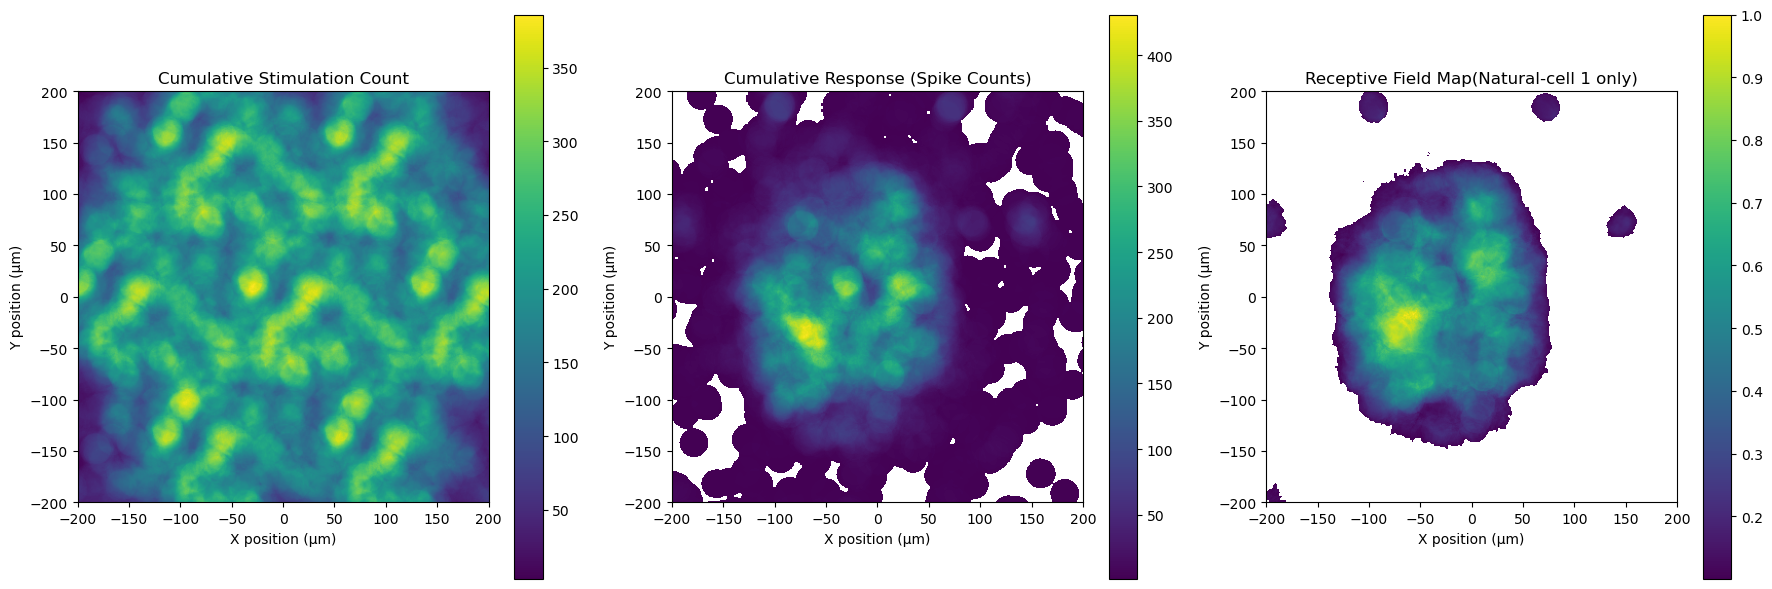

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(sum_stim_count_plotN, extent=extent,origin='lower')
axes[0].set_title('Cumulative Stimulation Count')
axes[0].set_xlabel('X position (µm)')
axes[0].set_ylabel('Y position (µm)')
fig.colorbar(im0, ax=axes[0], orientation='vertical')


im1 = axes[1].imshow(sum_response_plotN, extent=extent,origin='lower')
axes[1].set_title('Cumulative Response (Spike Counts)')
axes[1].set_xlabel('X position (µm)')
axes[1].set_ylabel('Y position (µm)')
fig.colorbar(im1, ax=axes[1], orientation='vertical')

im2 = axes[2].imshow(rf_plotN, extent=extent,origin='lower')
axes[2].set_title('Receptive Field Map(Natural-cell 1 only)')
axes[2].set_xlabel('X position (µm)')
axes[2].set_ylabel('Y position (µm)')
fig.colorbar(im2, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()

In [65]:
rows, cols = np.nonzero(rfN)
values = rfN[rows, cols]

grid_rows, grid_cols = np.mgrid[0:rfN.shape[0], 0:rfN.shape[1]]

rf_estimatedN = griddata(points=np.column_stack((rows, cols)),
                        values=values,
                        xi=(grid_rows, grid_cols),
                        method='linear')

rf_estimatedN = np.nan_to_num(rf_estimatedN, nan=0)

rf_blankN = rf_estimatedN.copy()
blank_maskN = (rf_estimatedN == 0)
rf_blankN[blank_maskN] = np.nan


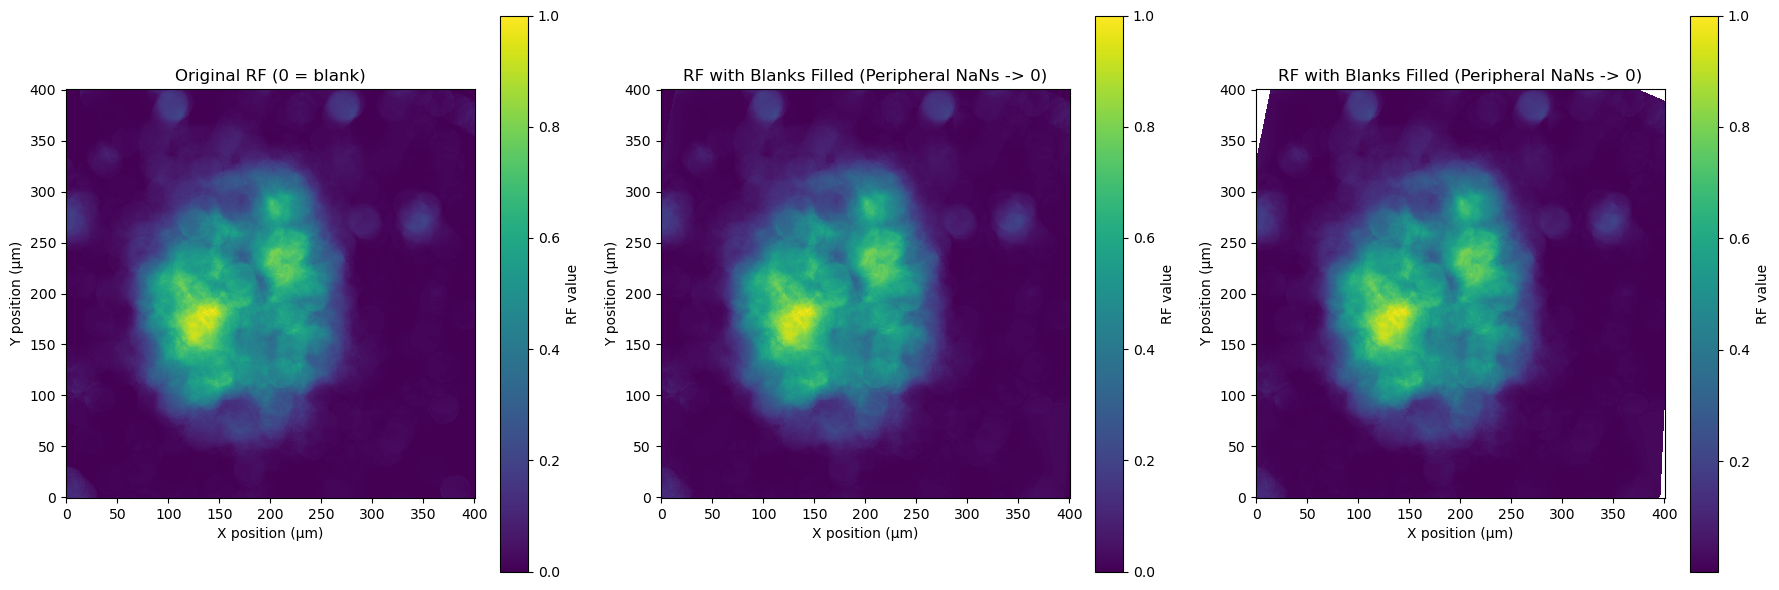

In [66]:

# --- Visualize the results ---
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(rfN, origin='lower', cmap='viridis', interpolation='none')
plt.title('Original RF (0 = blank)')
plt.xlabel('X position (µm)')
plt.ylabel('Y position (µm)')
plt.colorbar(label='RF value')

plt.subplot(1, 3, 2)
plt.imshow(rf_estimatedN, origin='lower', cmap='viridis', interpolation='none')
plt.title('RF with Blanks Filled (Peripheral NaNs -> 0)')
plt.xlabel('X position (µm)')
plt.ylabel('Y position (µm)')
plt.colorbar(label='RF value')

plt.subplot(1, 3, 3)
# plt.imshow(rf_blankN[550:951,550:951], origin='lower', cmap='viridis', interpolation='none')
plt.imshow(rf_blankN, origin='lower', cmap='viridis', interpolation='none')
plt.title('RF with Blanks Filled (Peripheral NaNs -> 0)')
plt.xlabel('X position (µm)')
plt.ylabel('Y position (µm)')
plt.colorbar(label='RF value')
plt.tight_layout()
plt.show()

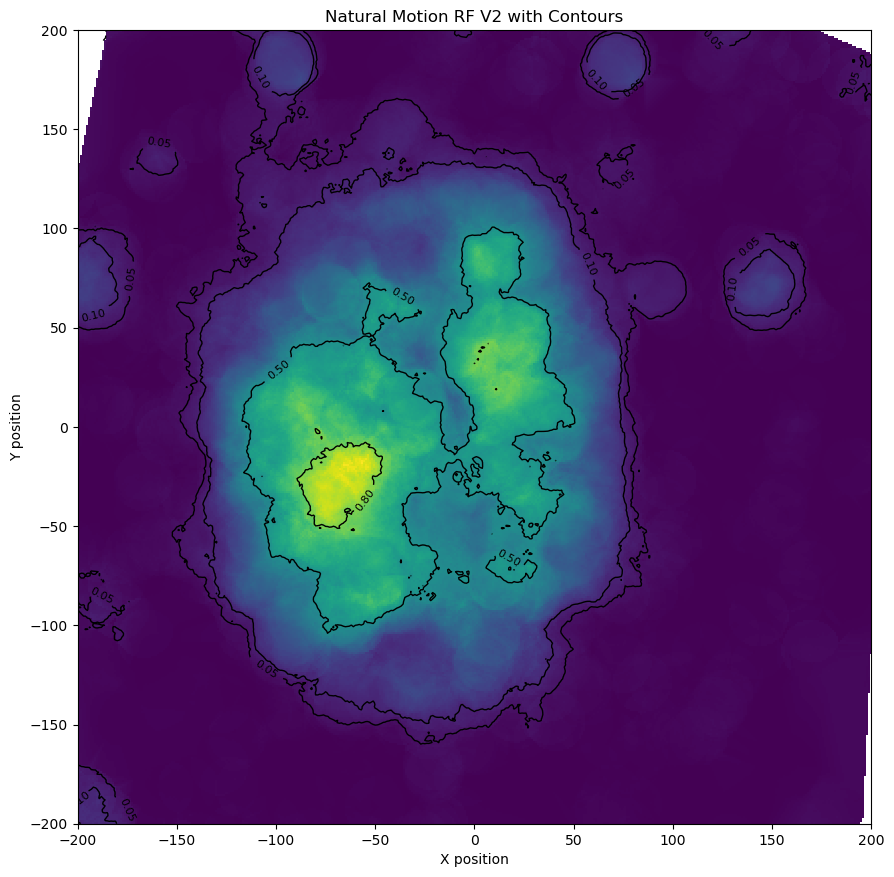

In [67]:
# Build spatial grid
board_range = [-(board_size/2), board_size/2]
x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
y_vals = np.linspace(board_range[0], board_range[1], board_size+1)


Xg, Yg = np.meshgrid(x_vals, y_vals)

fig, ax = plt.subplots(figsize=(9, 9))

im = ax.imshow(rf_blankN, origin='lower', extent=[board_range[0], board_range[1],board_range[0], board_range[1]], cmap='viridis', interpolation='none')

# Overlay RF contour lines
# cs = ax.contour(Xg, Yg, rf_blankN[550:951,550:951], levels=[0.05*np.nanmax(rf_blankN),
cs = ax.contour(Xg, Yg, rf_blankN, levels=[0.05*np.nanmax(rf_blankN),
                                              0.1*np.nanmax(rf_blankN),
                                              0.5*np.nanmax(rf_blankN),
                                              0.8*np.nanmax(rf_blankN),
                                              ],colors='k', linewidths=1,alpha=1)
ax.clabel(cs, inline=1, fmt='%.2f', fontsize=8)



ax.set_title('Natural Motion RF V2 with Contours')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')

plt.tight_layout()
plt.show()

# Receptive field V3- Control

In [ ]:
spikecountsC = []
for i in range(len(spike_indices_c)):
    countstemC, bin_edgesSF = np.histogram(spike_trains_cemd[i], bins=binsSF)
    spikecountsC.append(countstemC)

sum_responseC = np.zeros(board_shape, dtype=float)
sum_stim_countC = np.zeros(board_shape, dtype=float)
with h5py.File('results/stimulic2_cV3.h5', 'r') as f:
    movies_c     = f['stimuli']      # 4‑D dataset, chunked & compressed
    epochc = f['epoch_id']
    for trial_stim, trial_spike_counts,id in zip(movies_c, spikecountsC,epochc):
        if not id in epoch_c_nonrepeat:
            continue
        num_flashes = len(trial_spike_counts)
        for flash_idx in range(num_flashes):
            if flash_idx < delayedframes:
                continue
            
            group_start = flash_idx 
            stim_frame_idx = group_start - delayedframes 
            mask = trial_stim[stim_frame_idx]
            count = trial_spike_counts[flash_idx]
            sum_responseC += mask * count
            sum_stim_countC += mask


with np.errstate(divide='ignore', invalid='ignore'):
    rfC = np.true_divide(sum_responseC, sum_stim_countC)
    rfC[~np.isfinite(rfC)] = 0

rfC = rfC / np.max(rfC.flatten())
sum_response_plotC = sum_responseC.copy()
sum_response_plotC[sum_response_plotC == 0] = np.nan
sum_stim_count_plotC = sum_stim_countC.copy()
sum_stim_count_plotC[sum_stim_count_plotC == 0] = np.nan
rf_plotC = rfC.copy()
rf_plotC[rf_plotC == 0] = np.nan
np.save('results/rfC_V3.npy', rfC)

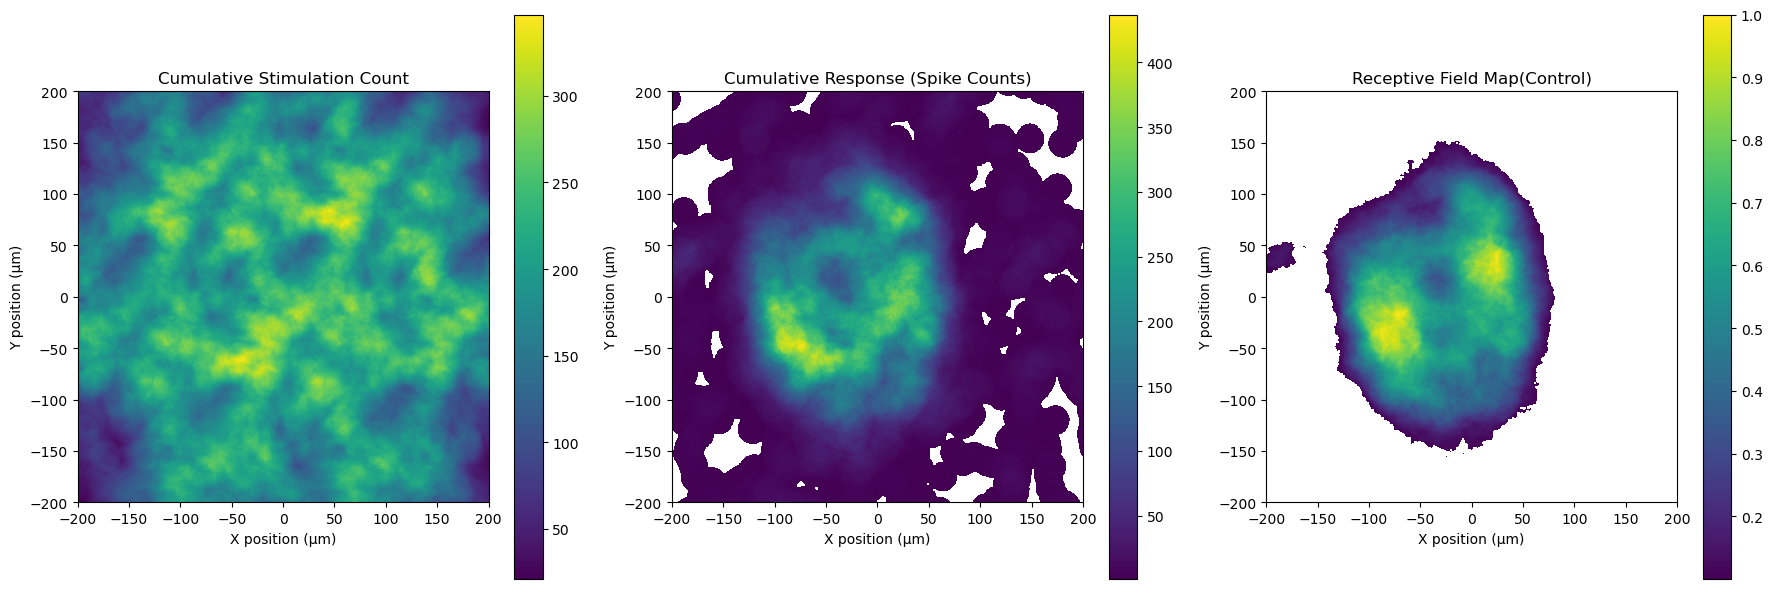

In [69]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(sum_stim_count_plotC, extent=extent,origin='lower')
axes[0].set_title('Cumulative Stimulation Count')
axes[0].set_xlabel('X position (µm)')
axes[0].set_ylabel('Y position (µm)')
fig.colorbar(im0, ax=axes[0], orientation='vertical')


im1 = axes[1].imshow(sum_response_plotC, extent=extent,origin='lower')
axes[1].set_title('Cumulative Response (Spike Counts)')
axes[1].set_xlabel('X position (µm)')
axes[1].set_ylabel('Y position (µm)')
fig.colorbar(im1, ax=axes[1], orientation='vertical')

im2 = axes[2].imshow(rf_plotC, extent=extent,origin='lower')
axes[2].set_title('Receptive Field Map(Control)')
axes[2].set_xlabel('X position (µm)')
axes[2].set_ylabel('Y position (µm)')
fig.colorbar(im2, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()

In [70]:
rows, cols = np.nonzero(rfC)
values = rfC[rows, cols]

grid_rows, grid_cols = np.mgrid[0:rfC.shape[0], 0:rfC.shape[1]]

rf_estimatedC = griddata(points=np.column_stack((rows, cols)),
                        values=values,
                        xi=(grid_rows, grid_cols),
                        method='linear')

rf_estimatedC = np.nan_to_num(rf_estimatedC, nan=0)

rf_blankC = rf_estimatedC.copy()
blank_maskC = (rf_estimatedC == 0)
rf_blankC[blank_maskC] = np.nan

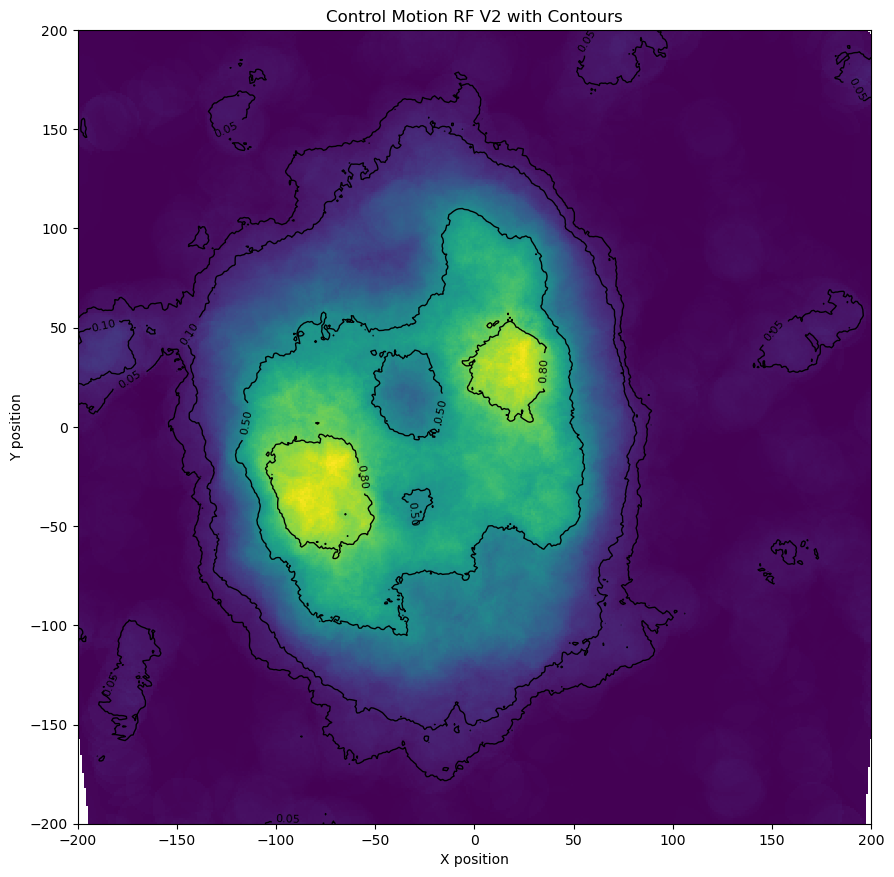

In [71]:
board_range = [-(board_size/2), board_size/2]
x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
y_vals = np.linspace(board_range[0], board_range[1], board_size+1)


Xg, Yg = np.meshgrid(x_vals, y_vals)

fig, ax = plt.subplots(figsize=(9, 9))

im = ax.imshow(rf_blankC, origin='lower', extent=[board_range[0], board_range[1],
                       board_range[0], board_range[1]], cmap='viridis', interpolation='none')



# Overlay RF contour lines
cs = ax.contour(Xg, Yg, rf_blankC, levels=[0.05*np.nanmax(rf_blankC),
                                              0.1*np.nanmax(rf_blankC),
                                              0.5*np.nanmax(rf_blankC),
                                              0.8*np.nanmax(rf_blankC),
                                              ],colors='k', linewidths=1,alpha=1)
ax.clabel(cs, inline=1, fmt='%.2f', fontsize=8)



ax.set_title('Control Motion RF V2 with Contours')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')

plt.tight_layout()
plt.show()

# Receptive Field - Flash

In [ ]:
spikecountsF = []
for i in range(len(spike_indices_f)):
    countstemF, bin_edgesSF = np.histogram(spike_trains_femd[i], bins=binsSF)
    spikecountsF.append(countstemF)

sum_responseF = np.zeros(board_shape, dtype=float)
sum_stim_countF = np.zeros(board_shape, dtype=float)
with h5py.File('results/stimulic2_fV3.h5', 'r') as f:
    movies_f     = f['stimuli']      # 4‑D dataset, chunked & compressed
    for trial_stim, trial_spike_counts in zip(movies_f, spikecountsF):
        num_flashes = len(trial_spike_counts)
        for flash_idx in range(num_flashes):
            if flash_idx < delayedframes:
                continue
            
            group_start = flash_idx 
            stim_frame_idx = group_start - delayedframes 
            mask = trial_stim[stim_frame_idx]
            count = trial_spike_counts[flash_idx]
            sum_responseF += mask * count
            sum_stim_countF += mask


with np.errstate(divide='ignore', invalid='ignore'):
    rfF = np.true_divide(sum_responseF, sum_stim_countF)
    rfF[~np.isfinite(rfF)] = 0

rfF = rfF / np.max(rfF.flatten())
sum_response_plotF = sum_responseF.copy()
sum_response_plotF[sum_response_plotF == 0] = np.nan
sum_stim_count_plotF = sum_stim_countF.copy()
sum_stim_count_plotF[sum_stim_count_plotF == 0] = np.nan
rf_plotF = rfF.copy()
rf_plotF[rf_plotF == 0] = np.nan
np.save('results/rfFc2V3.npy', rfF)

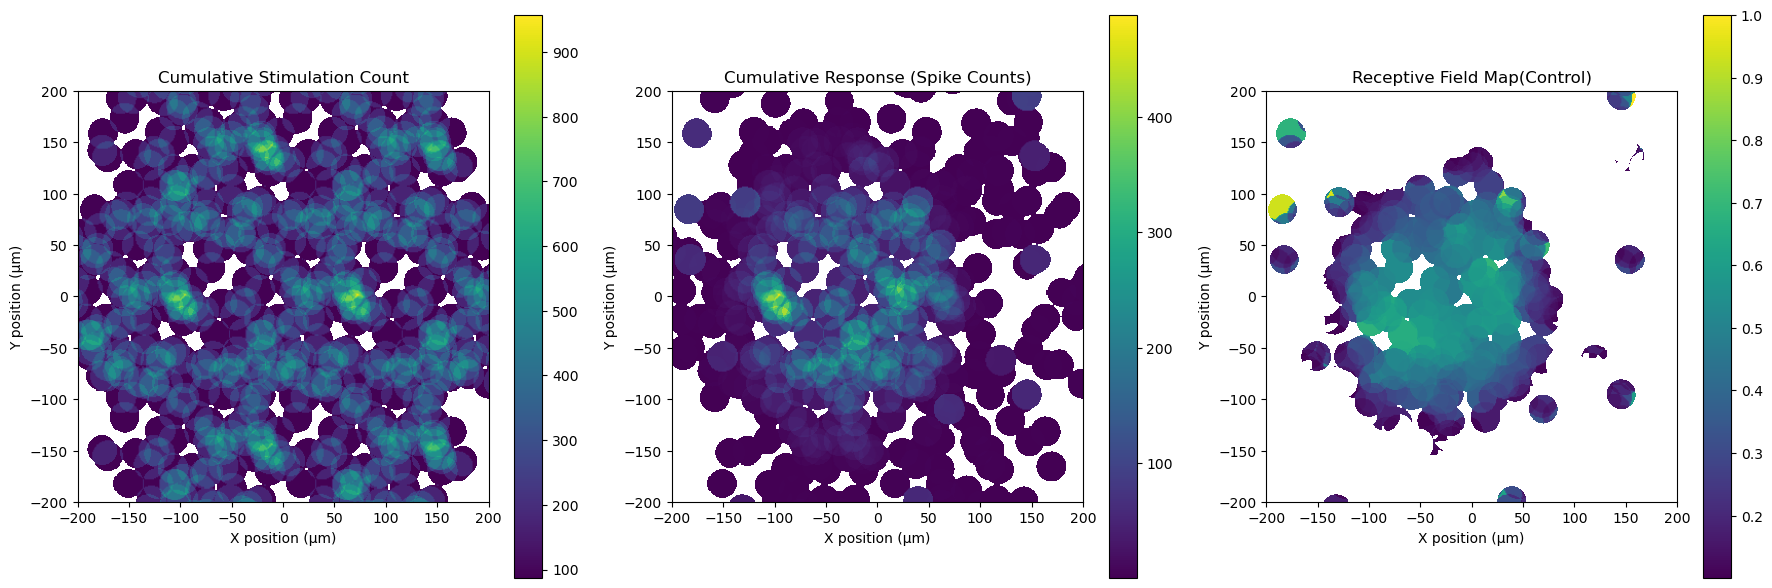

In [73]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(sum_stim_count_plotF, extent=extent,origin='lower')
axes[0].set_title('Cumulative Stimulation Count')
axes[0].set_xlabel('X position (µm)')
axes[0].set_ylabel('Y position (µm)')
fig.colorbar(im0, ax=axes[0], orientation='vertical')


im1 = axes[1].imshow(sum_response_plotF, extent=extent,origin='lower')
axes[1].set_title('Cumulative Response (Spike Counts)')
axes[1].set_xlabel('X position (µm)')
axes[1].set_ylabel('Y position (µm)')
fig.colorbar(im1, ax=axes[1], orientation='vertical')

im2 = axes[2].imshow(rf_plotF, extent=extent,origin='lower')
axes[2].set_title('Receptive Field Map(Control)')
axes[2].set_xlabel('X position (µm)')
axes[2].set_ylabel('Y position (µm)')
fig.colorbar(im2, ax=axes[2], orientation='vertical')

plt.tight_layout()
plt.show()

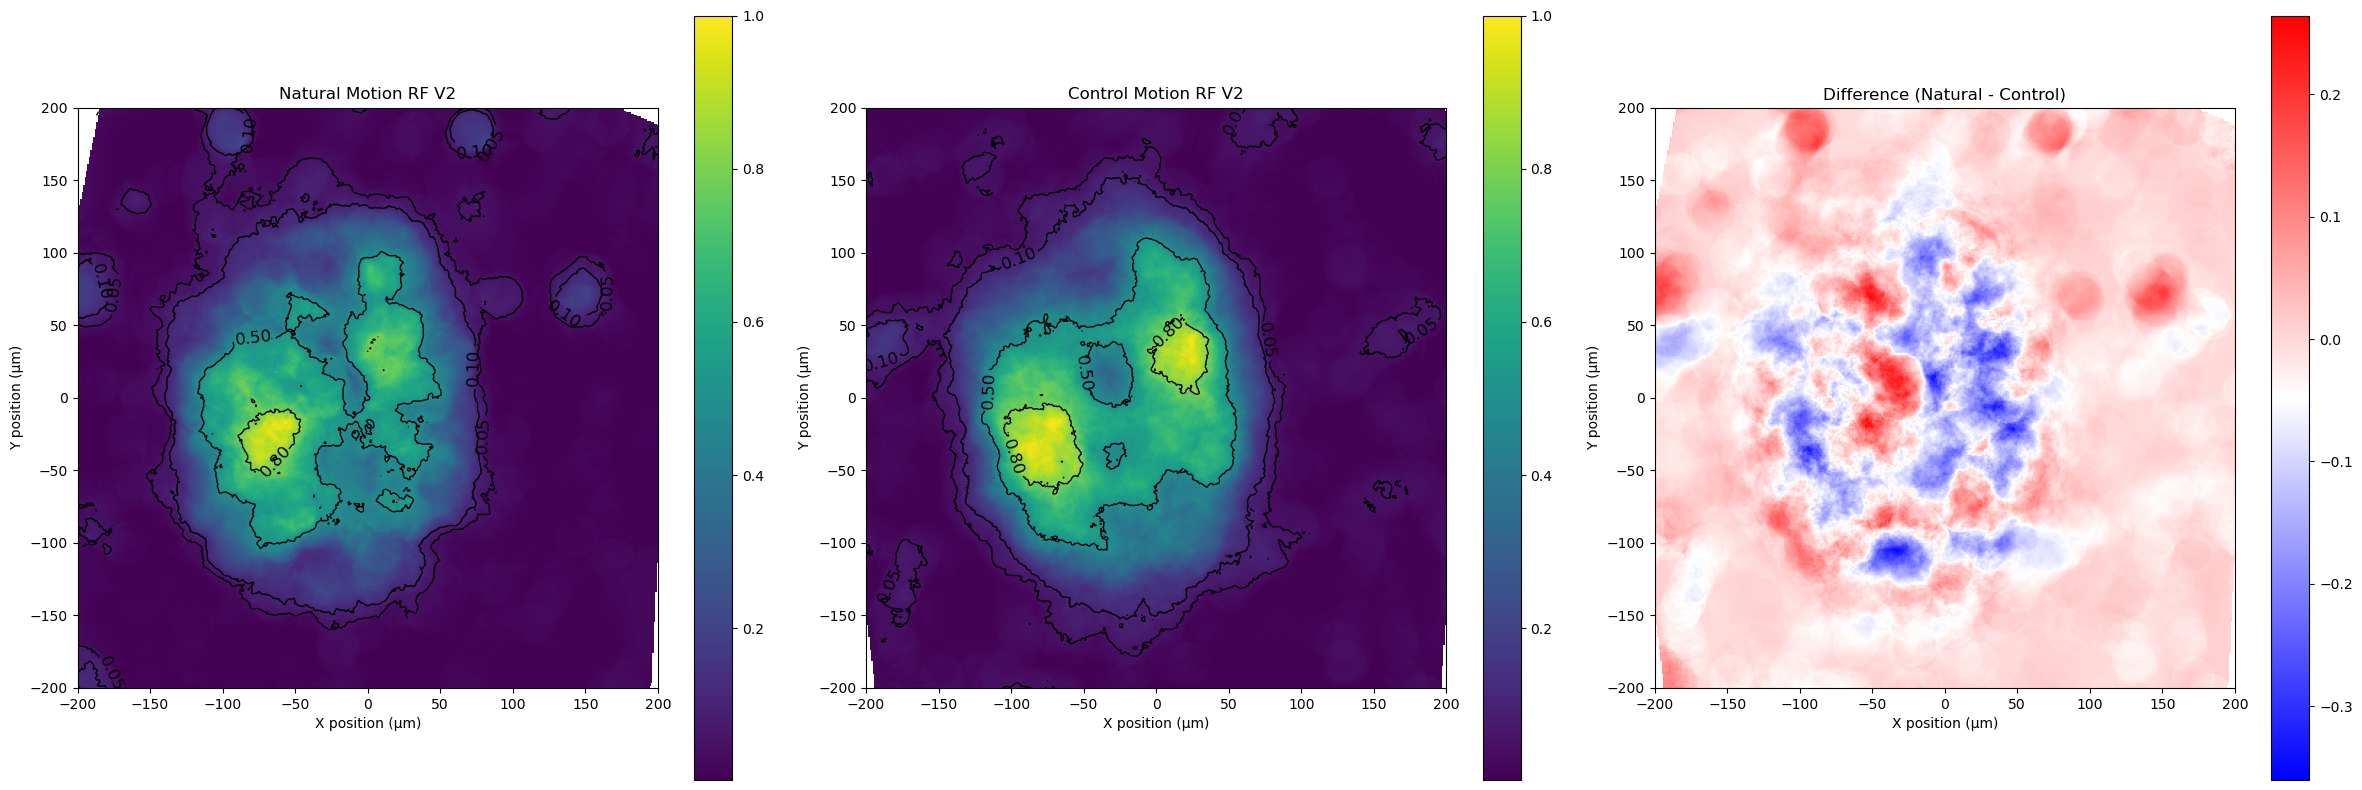

Pearson correlation between Natural and Control RFs: 0.967


In [74]:

# Assume rf_blankN, rf_blankC, board_size are already defined in your notebook
board_range = [-(board_size/2), board_size/2]
x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
Xg, Yg = np.meshgrid(x_vals, y_vals)

# Set color scale to be the same for both RFs
vmin = min(np.nanmin(rf_blankN), np.nanmin(rf_blankC))
vmax = max(np.nanmax(rf_blankN), np.nanmax(rf_blankC))

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Natural
im0 = axes[0].imshow(rf_blankN, origin='lower', extent=[board_range[0], board_range[1], board_range[0], board_range[1]], cmap='viridis', vmin=vmin, vmax=vmax)
cs0 = axes[0].contour(Xg, Yg, rf_blankN, levels=[0.05*np.nanmax(rf_blankN), 0.1*np.nanmax(rf_blankN), 0.5*np.nanmax(rf_blankN), 0.8*np.nanmax(rf_blankN)], colors='k', linewidths=1, alpha=1)
axes[0].clabel(cs0, inline=1, fmt='%.2f', fontsize=12)
axes[0].set_title('Natural Motion RF V2')
axes[0].set_xlabel('X position (µm)')
axes[0].set_ylabel('Y position (µm)')
fig.colorbar(im0, ax=axes[0])

# Control
im1 = axes[1].imshow(rf_blankC, origin='lower', extent=[board_range[0], board_range[1], board_range[0], board_range[1]], cmap='viridis', vmin=vmin, vmax=vmax)
cs1 = axes[1].contour(Xg, Yg, rf_blankC, levels=[0.05*np.nanmax(rf_blankC), 0.1*np.nanmax(rf_blankC), 0.5*np.nanmax(rf_blankC), 0.8*np.nanmax(rf_blankC)], colors='k', linewidths=1, alpha=1)
axes[1].clabel(cs1, inline=1, fmt='%.2f', fontsize=12)
axes[1].set_title('Control Motion RF V2')
axes[1].set_xlabel('X position (µm)')
axes[1].set_ylabel('Y position (µm)')
fig.colorbar(im1, ax=axes[1])

# Difference
diff = rf_blankN - rf_blankC
im2 = axes[2].imshow(diff, origin='lower', extent=[board_range[0], board_range[1], board_range[0], board_range[1]], cmap='bwr')
axes[2].set_title('Difference (Natural - Control)')
axes[2].set_xlabel('X position (µm)')
axes[2].set_ylabel('Y position (µm)')
fig.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

# Quantitative comparison
mask = ~np.isnan(rf_blankN) & ~np.isnan(rf_blankC)
corr = np.corrcoef(rf_blankN[mask].flatten(), rf_blankC[mask].flatten())[0, 1]
print(f"Pearson correlation between Natural and Control RFs: {corr:.3f}")

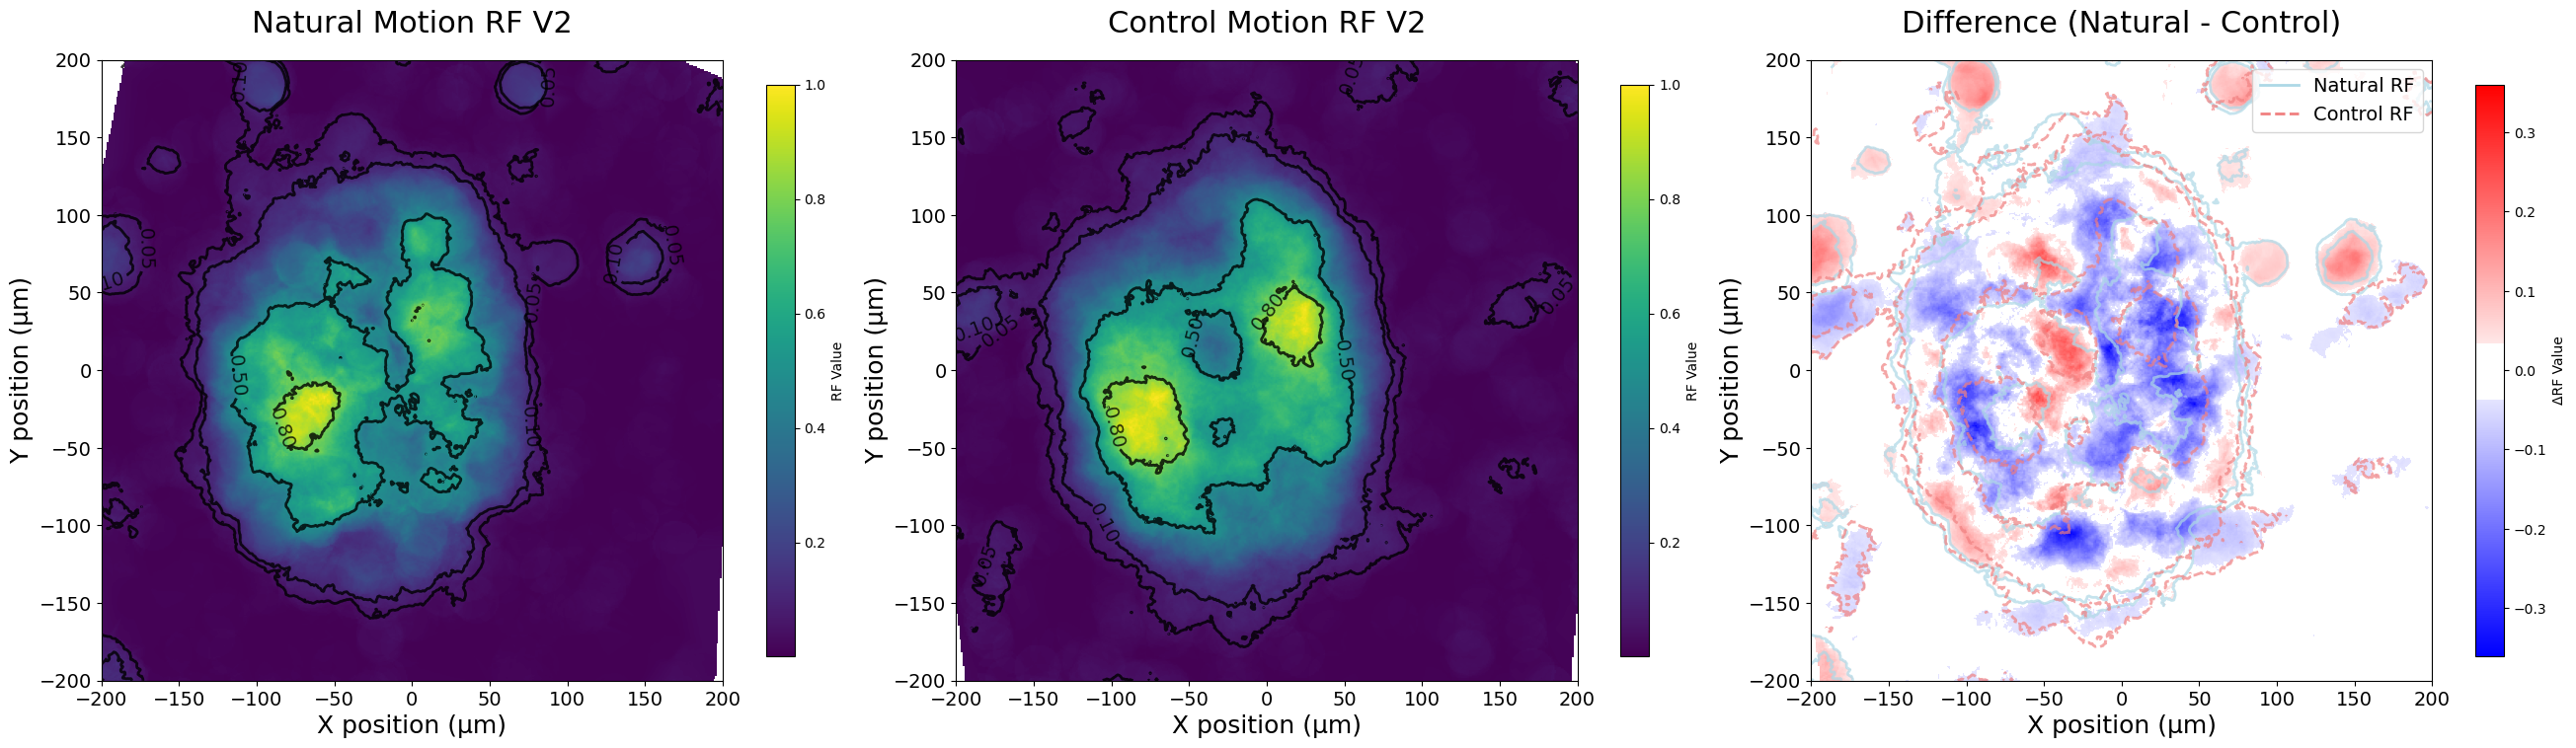

Pearson correlation between Natural and Control RFs: 0.967


In [75]:

from matplotlib import cm
from matplotlib.colors import ListedColormap

# Assume rf_blankN, rf_blankC, board_size are already defined
board_range = [-(board_size/2), board_size/2]
x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
Xg, Yg = np.meshgrid(x_vals, y_vals)



# Set color scale to be the same for both RFs
vmin = min(np.nanmin(rf_blankN), np.nanmin(rf_blankC))
vmax = max(np.nanmax(rf_blankN), np.nanmax(rf_blankC))

fig, axes = plt.subplots(1, 3, figsize=(26, 9), constrained_layout=True)

# --- Natural ---
im0 = axes[0].imshow(rf_blankN, origin='lower', extent=[board_range[0], board_range[1], board_range[0], board_range[1]],
                    cmap='viridis', vmin=vmin, vmax=vmax)
cs0 = axes[0].contour(Xg, Yg, rf_blankN, levels=[0.05*np.nanmax(rf_blankN), 0.1*np.nanmax(rf_blankN), 0.5*np.nanmax(rf_blankN), 0.8*np.nanmax(rf_blankN)],
                      colors='k', linewidths=2, alpha=0.8)
axes[0].clabel(cs0, inline=1, fmt='%.2f', fontsize=14)
axes[0].set_title('Natural Motion RF V2', fontsize=22, pad=20)
axes[0].set_xlabel('X position (µm)', fontsize=18)
axes[0].set_ylabel('Y position (µm)', fontsize=18)
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04, label='RF Value')

# --- Control ---
im1 = axes[1].imshow(rf_blankC, origin='lower', extent=[board_range[0], board_range[1], board_range[0], board_range[1]],
                    cmap='viridis', vmin=vmin, vmax=vmax)
cs1 = axes[1].contour(Xg, Yg, rf_blankC, levels=[0.05*np.nanmax(rf_blankC), 0.1*np.nanmax(rf_blankC), 0.5*np.nanmax(rf_blankC), 0.8*np.nanmax(rf_blankC)],
                      colors='k', linewidths=2, alpha=0.8)
axes[1].clabel(cs1, inline=1, fmt='%.2f', fontsize=14)
axes[1].set_title('Control Motion RF V2', fontsize=22, pad=20)
axes[1].set_xlabel('X position (µm)', fontsize=18)
axes[1].set_ylabel('Y position (µm)', fontsize=18)
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04, label='RF Value')

# --- Difference with custom colorbar ---
diff = rf_blankN - rf_blankC
diff_max = np.nanmax(np.abs(diff))

# Create custom colormap: white for [-0.05, 0.05], red-blue for others
colors = plt.cm.bwr(np.linspace(0, 1, 256))
# Find the middle range for white
mid_start = int(256 * (0.5 - 0.05))
mid_end = int(256 * (0.5 + 0.05))
colors[mid_start:mid_end] = [1, 1, 1, 1]  # White
custom_cmap = ListedColormap(colors)

im2 = axes[2].imshow(diff, origin='lower', extent=[board_range[0], board_range[1], board_range[0], board_range[1]],
                     cmap=custom_cmap, vmin=-diff_max, vmax=diff_max)

# Overlay contours from both Natural and Control on the difference map
# Natural contours in light blue
cs_n = axes[2].contour(Xg, Yg, rf_blankN, levels=[0.05*np.nanmax(rf_blankN), 0.1*np.nanmax(rf_blankN), 0.5*np.nanmax(rf_blankN), 0.8*np.nanmax(rf_blankN)],
                       colors='lightblue', linewidths=2, alpha=0.7, linestyles='-')
# Control contours in light red
cs_c = axes[2].contour(Xg, Yg, rf_blankC, levels=[0.05*np.nanmax(rf_blankC), 0.1*np.nanmax(rf_blankC), 0.5*np.nanmax(rf_blankC), 0.8*np.nanmax(rf_blankC)],
                       colors='lightcoral', linewidths=2, alpha=0.7, linestyles='--')

axes[2].set_title('Difference (Natural - Control)', fontsize=22, pad=20)
axes[2].set_xlabel('X position (µm)', fontsize=18)
axes[2].set_ylabel('Y position (µm)', fontsize=18)
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04, label='ΔRF Value')

# Add legend for contours
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='lightblue', lw=2, label='Natural RF'),
                   Line2D([0], [0], color='lightcoral', lw=2, linestyle='--', label='Control RF')]
axes[2].legend(handles=legend_elements, loc='upper right', fontsize=14)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()

# Quantitative comparison
mask = ~np.isnan(rf_blankN) & ~np.isnan(rf_blankC)
corr = np.corrcoef(rf_blankN[mask].flatten(), rf_blankC[mask].flatten())[0, 1]
print(f"Pearson correlation between Natural and Control RFs: {corr:.3f}")

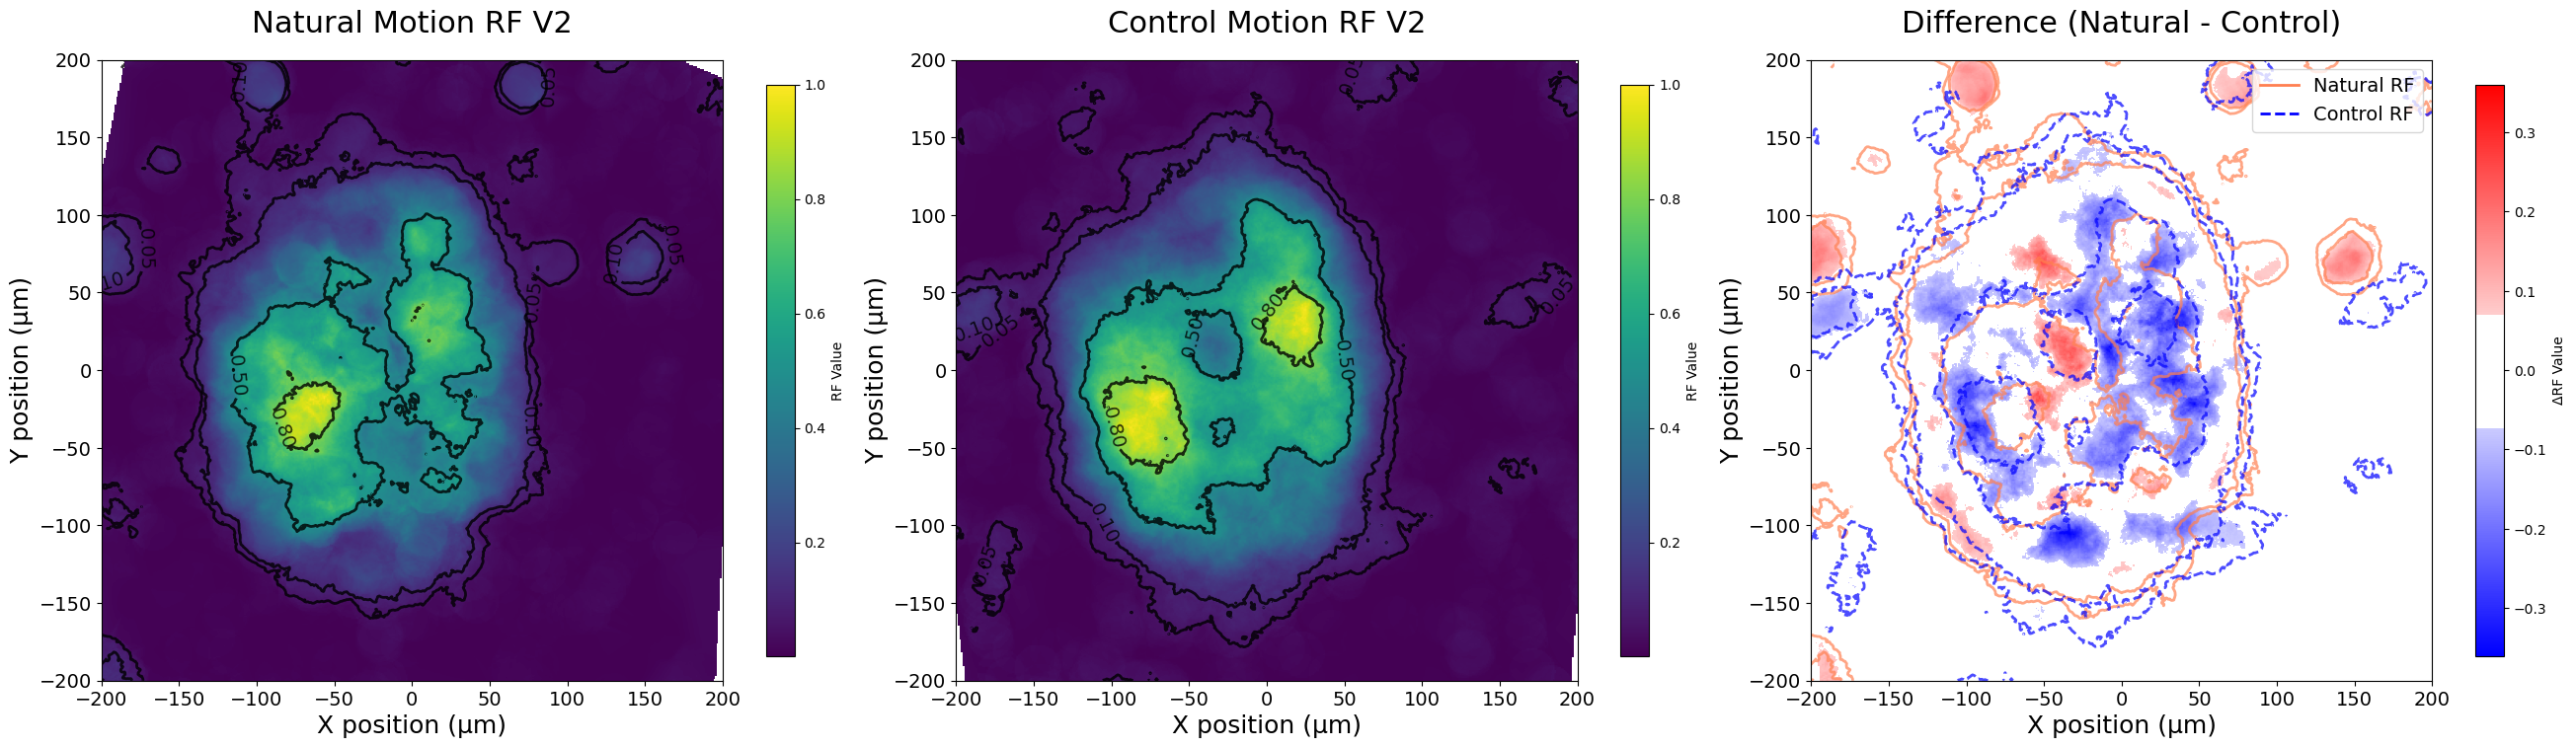

Pearson correlation between Natural and Control RFs: 0.967


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

# Assume rf_blankN, rf_blankC, board_size are already defined
board_range = [-(board_size/2), board_size/2]
x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
Xg, Yg = np.meshgrid(x_vals, y_vals)

# Set color scale to be the same for both RFs
vmin = min(np.nanmin(rf_blankN), np.nanmin(rf_blankC))
vmax = max(np.nanmax(rf_blankN), np.nanmax(rf_blankC))

fig, axes = plt.subplots(1, 3, figsize=(26, 9), constrained_layout=True)

# --- Natural ---
im0 = axes[0].imshow(rf_blankN, origin='lower', extent=[board_range[0], board_range[1], board_range[0], board_range[1]],
                    cmap='viridis', vmin=vmin, vmax=vmax)
cs0 = axes[0].contour(Xg, Yg, rf_blankN, levels=[0.05, 0.1, 0.5, 0.8], colors='k', linewidths=2, alpha=0.8)
axes[0].clabel(cs0, inline=1, fmt='%.2f', fontsize=14)
axes[0].set_title('Natural Motion RF V2', fontsize=22, pad=20)
axes[0].set_xlabel('X position (µm)', fontsize=18)
axes[0].set_ylabel('Y position (µm)', fontsize=18)
fig.colorbar(im0, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04, label='RF Value')

# --- Control ---
im1 = axes[1].imshow(rf_blankC, origin='lower', extent=[board_range[0], board_range[1], board_range[0], board_range[1]],
                    cmap='viridis', vmin=vmin, vmax=vmax)
cs1 = axes[1].contour(Xg, Yg, rf_blankC, levels=[0.05, 0.1, 0.5, 0.8], colors='k', linewidths=2, alpha=0.8)
axes[1].clabel(cs1, inline=1, fmt='%.2f', fontsize=14)
axes[1].set_title('Control Motion RF V2', fontsize=22, pad=20)
axes[1].set_xlabel('X position (µm)', fontsize=18)
axes[1].set_ylabel('Y position (µm)', fontsize=18)
fig.colorbar(im1, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04, label='RF Value')

# --- Difference with custom colorbar ---
diff = rf_blankN - rf_blankC
diff_max = np.nanmax(np.abs(diff))

# Create custom colormap: white for [-0.05, 0.05], red-blue for others
colors = plt.cm.bwr(np.linspace(0, 1, 256))
# Find the middle range for white
mid_start = int(256 * (0.5 - 0.1))
mid_end = int(256 * (0.5 + 0.1))
colors[mid_start:mid_end] = [1, 1, 1, 1]  # White
custom_cmap = ListedColormap(colors)

im2 = axes[2].imshow(diff, origin='lower', extent=[board_range[0], board_range[1], board_range[0], board_range[1]],
                     cmap=custom_cmap, vmin=-diff_max, vmax=diff_max)

# Overlay contours from both Natural and Control on the difference map
# Natural contours in light blue
cs_n = axes[2].contour(Xg, Yg, rf_blankN, levels=[0.05, 0.1, 0.5, 0.8], colors='coral', linewidths=2, alpha=0.7, linestyles='-')
# Control contours in light red
cs_c = axes[2].contour(Xg, Yg, rf_blankC, levels=[0.05, 0.1, 0.5, 0.8], colors='blue', linewidths=2, alpha=0.7, linestyles='--')

axes[2].set_title('Difference (Natural - Control)', fontsize=22, pad=20)
axes[2].set_xlabel('X position (µm)', fontsize=18)
axes[2].set_ylabel('Y position (µm)', fontsize=18)
fig.colorbar(im2, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04, label='ΔRF Value')

# Add legend for contours
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='coral', lw=2, label='Natural RF'),
                   Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Control RF')]
axes[2].legend(handles=legend_elements, loc='upper right', fontsize=14)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()

# Quantitative comparison
mask = ~np.isnan(rf_blankN) & ~np.isnan(rf_blankC)
corr = np.corrcoef(rf_blankN[mask].flatten(), rf_blankC[mask].flatten())[0, 1]
print(f"Pearson correlation between Natural and Control RFs: {corr:.3f}")